# Transcriptomics visualizations
Now that we've used R to get the differentially expressed genes, we can do some visualizations of what those look like for different comparisons.

In [1]:
from os import listdir
from os.path import splitext, abspath
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
from tqdm import tqdm
from collections import defaultdict, Counter
import subprocess
import sys
sys.path.append('../utils/')
%load_ext autoreload
%autoreload 2
from get_arabidopsis_descriptions import get_arabidopsis_descriptions
from upsetplot import from_contents, plot, UpSet
import warnings
import json

## Read in the data

In [2]:
datapath = '../data/deseq2_output/'
time_comparisons = {}
o2_comparisons = {}
for f in listdir(datapath):
    name = '_'.join(f.split('_')[:4])
    if f.split('_')[1] == 'vs':
        time_comparisons[name] = pd.read_csv(datapath+f)
    elif f.split('_')[1] == 'o2':
        o2_comparisons[name] = pd.read_csv(datapath+f)

In [3]:
time_comparisons.keys(), o2_comparisons.keys()

(dict_keys(['1h_vs_7h_2o2', '1h_vs_7h_40o2', '1h_vs_7h_21o2']),
 dict_keys(['1h_o2_40_21', '7h_o2_2_21', '1h_o2_2_21', '7h_o2_40_21']))

## Time comparisons
First, let's take a look at the distributions of the log fold change for the 1 hour vs. 7 hour comparisons.

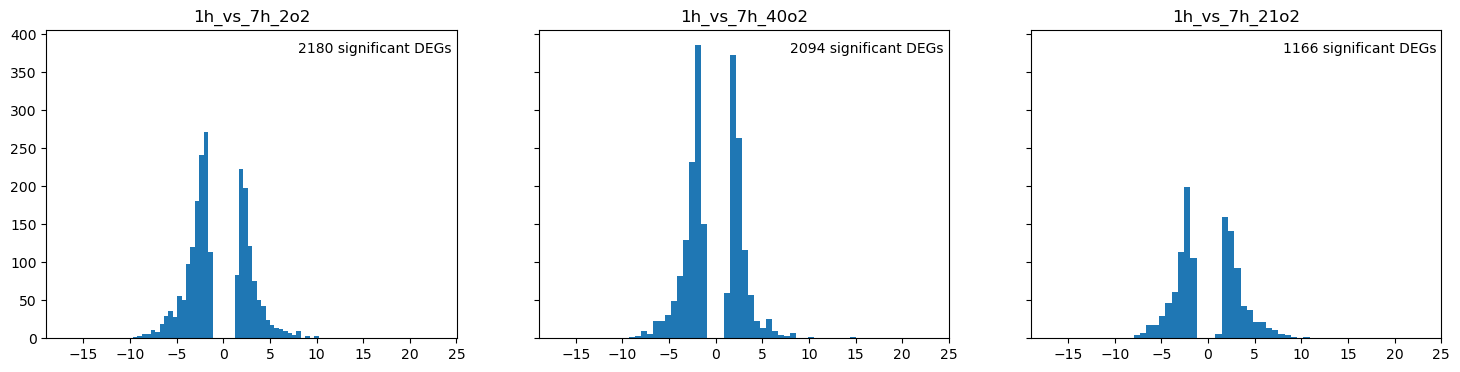

In [4]:
fig, axs = plt.subplots(1, len(time_comparisons), sharex=True, sharey=True, figsize=(len(time_comparisons)*6, 4))

for ax, comp in zip(axs, time_comparisons):
    ax.hist(time_comparisons[comp].log2FoldChange, bins=50)
    ax.set_title(comp)
    ax.text(8, 375, f'{len(time_comparisons[comp])} significant DEGs')

The presence of so many DEGs after 7 hours at ambient oxygen to me indicates that many of the DEGs we're seeing in the other conditions aren't related to the change in photorespiration as induced by the change in oxygen, but rather normal processed that change over the course of a day. What happens to these distributions if we remove the DEGs from 2% and 40% that are also found with the same directional change in 21%?

In [5]:
two_21_merged = pd.merge(time_comparisons['1h_vs_7h_2o2'], time_comparisons['1h_vs_7h_21o2'], left_on='gene_id', right_on='gene_id', suffixes=('_2o2', '_21o2'))
two_to_drop = two_21_merged[two_21_merged.log2FoldChange_2o2 * two_21_merged.log2FoldChange_21o2 > 0].gene_id
two_filtered_by_21 = time_comparisons['1h_vs_7h_2o2'][~time_comparisons['1h_vs_7h_2o2'].gene_id.isin(two_to_drop)].reset_index(drop=True)
two_filtered_by_21.shape

(1492, 7)

In [6]:
forty_21_merged = pd.merge(time_comparisons['1h_vs_7h_40o2'], time_comparisons['1h_vs_7h_21o2'], left_on='gene_id', right_on='gene_id', suffixes=('_40o2', '_21o2'))
forty_to_drop = forty_21_merged[forty_21_merged.log2FoldChange_40o2 * forty_21_merged.log2FoldChange_21o2 > 0].gene_id
forty_filtered_by_21 = time_comparisons['1h_vs_7h_40o2'][~time_comparisons['1h_vs_7h_40o2'].gene_id.isin(forty_to_drop)].reset_index(drop=True)
forty_filtered_by_21.shape

(1280, 7)

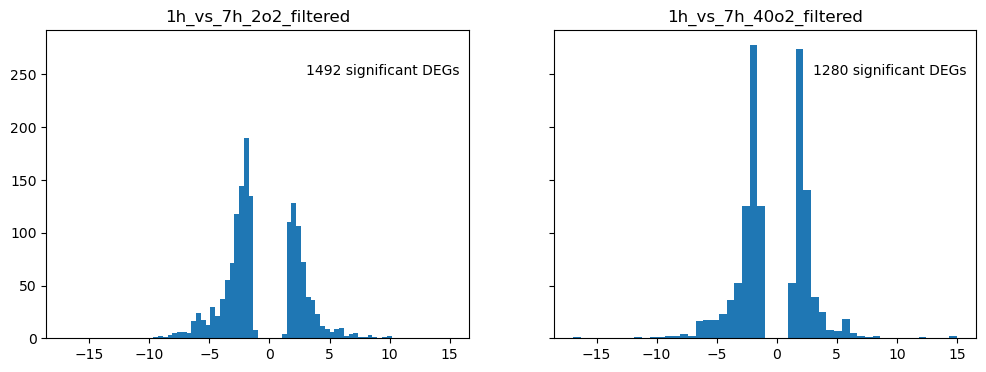

In [7]:
comps_filtered = {
    '1h_vs_7h_2o2_filtered': two_filtered_by_21,
    '1h_vs_7h_40o2_filtered': forty_filtered_by_21
}
fig, axs = plt.subplots(1, len(comps_filtered), sharex=True, sharey=True, figsize=(len(comps_filtered)*6, 4))

for ax, comp in zip(axs, comps_filtered):
    ax.hist(comps_filtered[comp].log2FoldChange, bins=50)
    ax.set_title(comp)
    ax.text(3, 250, f'{len(comps_filtered[comp])} significant DEGs')

That substantially reduces the number of genes we're interested in looking at. Now we can look at a volcano plot, which plots the log fold change against the p-value of the change:

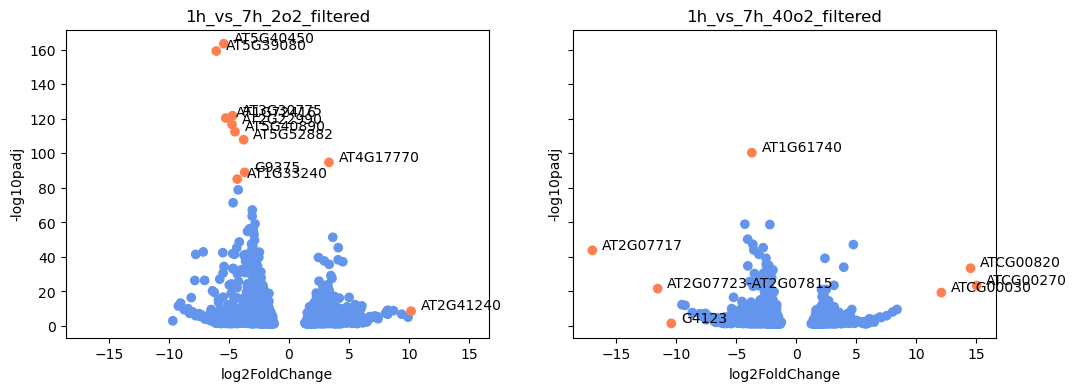

In [8]:
fig, axs = plt.subplots(1, len(comps_filtered), sharex=True, sharey=True, figsize=(len(comps_filtered)*6, 4))

for ax, comp in zip(axs, comps_filtered):
    x = comps_filtered[comp].log2FoldChange
    y = -np.log10(comps_filtered[comp].padj)
    colors = ['coral' if (abs(x_i) > 10 or y_i > 80) else 'cornflowerblue' for x_i, y_i in zip(x, y)]
    ax.scatter(x, y, c=colors)
    # Add gene name labels for the far out ones
    for i in range(len(x)):
        if colors[i] == 'coral':
            ax.annotate(comps_filtered[comp].loc[i, 'gene_id'], (x[i], y[i]), xytext=(x[i]+0.8, y[i]+0.8))

    ax.set_title(comp)
    ax.set_xlabel('log2FoldChange')
    ax.set_ylabel('-log10padj')

Generally speaking, we are interested in genes that have opposite responses at 2% vs. 40% oxygen, as the photorespiratory demands of those two conditions are opposite. Let's take a look at what genes fit that description for the hour comparisons:

In [9]:
two_forty = pd.merge(two_filtered_by_21, forty_filtered_by_21, left_on='gene_id', right_on='gene_id', suffixes=('_2o2', '_40o2'))

In [10]:
opposites_hour = two_forty[two_forty['log2FoldChange_2o2']*two_forty['log2FoldChange_40o2'] < 0]
opposites_hour.shape

(12, 13)

That gives us 12 genes, which is a very manageable number!

## Oxygen comparisons
Before we dive into the time comparison opposite behavior genes, let's look at the comparisons of each oxygen level at the two timepoints. We can then cross-reference the genes of interest that we find in order to narrow down our list even further. Let's start with the same basic visualizations as we did for the time comparisons:

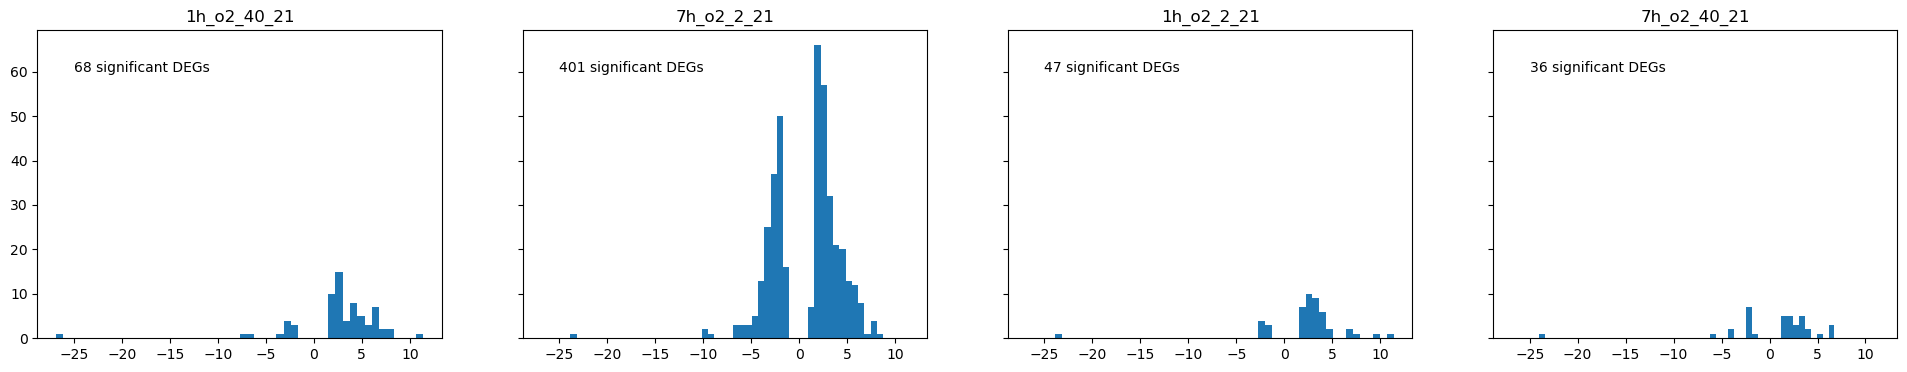

In [11]:
fig, axs = plt.subplots(1, len(o2_comparisons), sharex=True, sharey=True, figsize=(len(o2_comparisons)*6, 4))

for ax, comp in zip(axs, o2_comparisons):
    ax.hist(o2_comparisons[comp].log2FoldChange, bins=50)
    ax.set_title(comp)
    ax.text(-25, 60, f'{len(o2_comparisons[comp])} significant DEGs')

Now this is interesting; we have much more skewed distributions for these comparisons, and there are many fewer genes being differentially expressed in these comparisons. Interestingly, note that there are substantially more DEGs at 7 hours in the 2% samples; this is the condition that showed a return to ambient levels of phi2. As before, we're interested in genes that have opposite behaviors between 2% and 40%; abut I am also now curious about the large number of DEGs in 2% at 7 hours.

For the time comparisons, we made the assumption that DEGs at 21% oxygen that appeared in the 2% or 40% treatments could be removed because we're interested in the differences from the ambient condition. Similarly here, we could make the assumption that the 1 hour time point is more or less the same as ambient and remove those genes from the 7 hour timepoints. However, given that the oxygen groupings separated on the PCA at 1 hour, I am not sure this is a valid assumption. To put that assumption to the test, let's see how many DEGs are in common between the oxygen comparisons at 1 hour, regardless of their directionality. If the 1 hour timepoint isn't meaningful biologically, then I would expect that most of the DEGs are in common between the two conditions.

In [12]:
shared = set(o2_comparisons['1h_o2_2_21'].gene_id).intersection(o2_comparisons['1h_o2_40_21'].gene_id)
print(f'There are {len(shared)} genes in common  between the oxygen conditions at 1 hour. This represents {(len(shared)/len(o2_comparisons["1h_o2_2_21"]))*100:.2f}% '
     f'of the total DEGs for 2% oxygen at 1 hour, and {(len(shared)/len(o2_comparisons["1h_o2_40_21"]))*100:.2f}%  of the total DEGs for 40% oxygen at 1 hour.')

There are 15 genes in common  between the oxygen conditions at 1 hour. This represents 31.91% of the total DEGs for 2% oxygen at 1 hour, and 22.06%  of the total DEGs for 40% oxygen at 1 hour.


Ok so a reasonable proportion of them are in common (at least from the perspective of presence/absence), but it's less than 1/3rd for both conditions. I am therefore going to treat the 1 hour condition as having biologically meaningful expression differences as induced by the changes in oxygen. We'll therefore look at the genes that have opposite behaviors between the oxygen conditions for both timepoints separately, and then we can dig in and see if any of those DEGs are the same for the two timepoints in a given condition (the thought being that maybe something that starts having differential expression at 1 hour has stronger differential expression at 7 hours).

In [13]:
hour1 = pd.merge(o2_comparisons['1h_o2_2_21'], o2_comparisons['1h_o2_40_21'], left_on='gene_id', right_on='gene_id', suffixes=('_2o2', '_40o2'))
opposites_hour1 = hour1[hour1['log2FoldChange_2o2']*hour1['log2FoldChange_40o2'] < 0]

In [14]:
hour7 = pd.merge(o2_comparisons['7h_o2_2_21'], o2_comparisons['7h_o2_40_21'], left_on='gene_id', right_on='gene_id', suffixes=('_2o2', '_40o2'))
opposites_hour7 = hour7[hour7['log2FoldChange_2o2']*hour7['log2FoldChange_40o2'] < 0]

In [15]:
print(f'There are {len(opposites_hour1)} opposite-behavior DEGs at 1 hour, and {len(opposites_hour7)} at 7 hours.')

There are 0 opposite-behavior DEGs at 1 hour, and 5 at 7 hours.


That is way fewer than I expected! Firstly, this means that the genes in common between the two conditions at hour 1 are both regulated in the same direction. This actually supports the idea that there is not much biologically meaningful going on at 1 hour that's caused by the changes in oxygen; however, this analysis doesn't account for the greater portion of genes that the two conditions don't have in common.

## Time and Oxygen
There are also substantially fewer genes with opposite behavior at the 7 hour time point. Are any of these in common with our opposite behavior genes from the time comparison?

In [16]:
all_opposite = set(opposites_hour.gene_id).intersection(set(opposites_hour7.gene_id))
all_opposite

{'AT5G24490'}

Only one is in common; what is this gene? According to the [GO annotations in TAIR for this gene](https://www.arabidopsis.org/locus?name=AT5G24490#), the gene is involved in negative regulation of translational elongation and its gene product is located in the chloroplast. Is this potentially indicative of the fact that it's at the protein translational level where most of the important changes are taking place in response to oxygen? What directions does it go in the various conditions?

In [17]:
gene_of_interest = list(all_opposite)[0]
gene_of_interest_behaviors = {}
all_comparisons = time_comparisons
all_comparisons.update(o2_comparisons)
for comp, df in all_comparisons.items():
    try:
        gene_of_interest_behaviors[comp] = list(df[df['gene_id'] == gene_of_interest]['log2FoldChange'])[0]
    except IndexError:
        continue # Skips conditions where the gene doesn't appear

In [18]:
# Give some easier to parse labels for the plot
parsable_condition_names = {
    '1h_vs_7h_2o2': '1h vs. 7h\n2% oxygen',
    '1h_vs_7h_40o2': '1h vs. 7h\n40% oxygen',
    '7h_o2_2_21': '2% vs. 21%\n1 hour',
    '7h_o2_40_21': '40% vs. 21%\n1 hour'
}

Text(0.5, 1.0, 'Expression behavior of gene AT5G24490 across conditions where it appears')

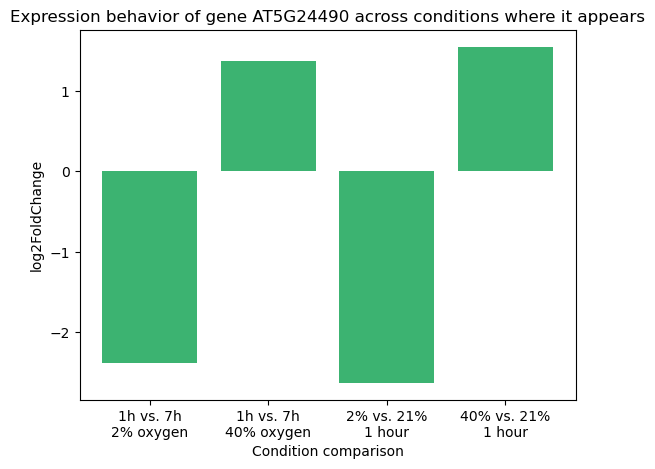

In [19]:
fig, ax = plt.subplots()

ax.bar([parsable_condition_names[k] for k in gene_of_interest_behaviors.keys()], gene_of_interest_behaviors.values(), color='mediumseagreen')
ax.set_xlabel('Condition comparison')
ax.set_ylabel('log2FoldChange')
ax.set_title(f'Expression behavior of gene {gene_of_interest} across conditions where it appears')

## Visualization of set overlaps
We can use UpSet plots to visualize our results better across all sets.

In [20]:
genes_in_comps = {}
for comp, df in all_comparisons.items():
    genes_in_comps[comp] = list(set(df.gene_id.tolist()))

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

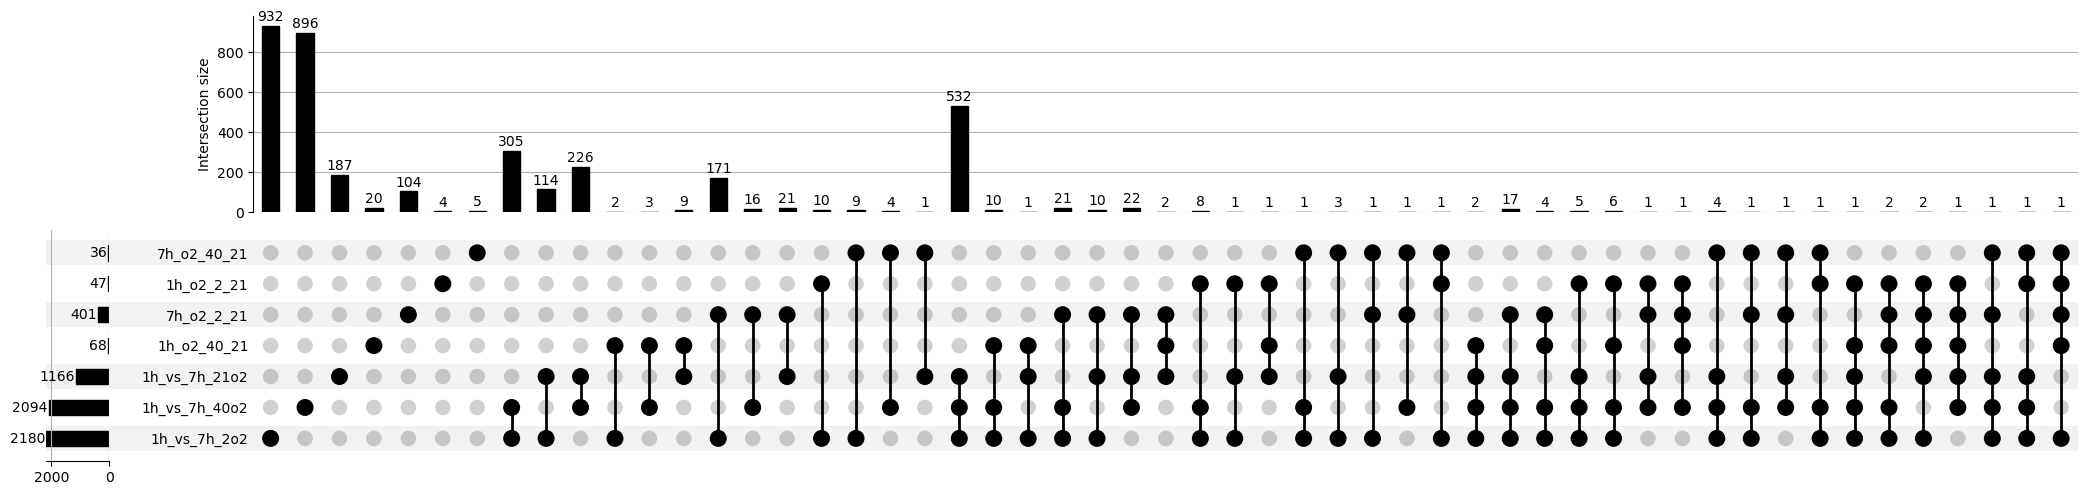

In [21]:
warnings.filterwarnings('ignore') 
to_plot = from_contents(genes_in_comps)
plot(to_plot, show_counts=True, sort_categories_by='input')

## Presence of photosynthetic machinery

A standing hypothesis made by physiologists about apparatuses like photosynthesis is that we wouldn't necessarily expect to see changes at the omics level in response to an environmental stimulus, because the cost of not responding fast enough is high enough that the plant would have all the machinery onboard already. We can test this hypothesis by looking for the presence of photosynthetically-related machinery in our differentially expressed genes. We'll import gene ID's to seach for from a few sources:

* The GreenCut gene list
* A list of genes involved in carbohydrate metabolism
* Photorespiration genes

While there does not exist a comprehensive list of the genes involved in the light reactions, I was able to find a resource in the supplemental data of [this paper](https://pmc.ncbi.nlm.nih.gov/articles/PMC9822700/#_ad93), of light reaction-related genes that are differentially expressed under certain conditions. Looking through the genes included, it appears as if the genes that code for subunits of the major players in photosynthesis are included.

In [48]:
with open('../data/photosynthesis_genes/carb_metabolism_genes.txt') as f:
    carb_met = [l.strip().lower() for l in f.readlines()]
carb_met[:5]

['at4g24620', 'at5g51820', 'at5g19220', 'at1g27680', 'at4g39210']

In [49]:
with open('../data/photosynthesis_genes/photorespiration_genes.txt') as f:
    photorespiration = [l.strip().lower() for l in f.readlines()]
photorespiration[:5]

['at5g36700', 'at3g14420', 'at4g35090', 'at1g23310', 'at1g70580']

In [50]:
with open('../data/photosynthesis_genes/plastidCut2_genes.txt') as f:
    plastid_cut = [l.strip().lower() for l in f.readlines()]
plastid_cut[:5]

['at1g06690', 'at4g32770', 'at2g41040', 'at5g57030', 'at3g59890']

In [51]:
light_rxn_dfs = pd.read_excel('../data/photosynthesis_genes/PLD3-7-e475-s003.xlsx', sheet_name=None, header=2)
light_rxn_dfs.keys()

dict_keys(['ATP_synthase_DEG_DEseq2', 'Calvin Cycle', 'Cyclic_Electron_Flow_switch', 'Cytochrome_B6f_complex', 'LHCI proteins', 'LHCII proteins', 'NDA complex', 'Other_components_Electron_Flow', 'PSI Core proteins ', 'PSII core proteins', 'Regulatory Protein'])

In [52]:
light_rxn_dfs['ATP_synthase_DEG_DEseq2'].columns = light_rxn_dfs['ATP_synthase_DEG_DEseq2'].iloc[1]
light_rxn_dfs['ATP_synthase_DEG_DEseq2'] = light_rxn_dfs['ATP_synthase_DEG_DEseq2'].drop([0,1])
light_rxn_dfs['ATP_synthase_DEG_DEseq2']

1,gene,Sinusoidal Log2 Fold change,p.adjusted_S,Fluctuation Log2 Fold change,p.adjusted_F,AVG_TPM_C,AVG_TPM_S,AVG_TPM_F,Gene.name,Gene.Brief.Description
2,AT1G15700,-0.027932,0.87935,-0.35866,0.013251,4.76198,5.042359,4.069887,atpC2,"ATPase, F1 complex, gamma subunit protein"
3,AT4G32260,-0.148713,0.214356,-0.120932,0.325655,1631.566665,1577.776042,1618.384295,PDE334,"ATPase, F0 complex, subunit B/B', bacterial/ch..."
4,AT4G04640,-0.263944,0.000198,-0.080148,0.322218,1320.435898,1178.609476,1353.29015,atpC1,"ATPase, F1 complex, gamma subunit protein"
5,AT4G09650,-0.362608,0.001301,-0.214111,0.073365,1845.820232,1538.966136,1716.254467,atpD,F-type H -transporting ATPase subunit delta


In [193]:
light_rxn_dfs['NDA complex']

,gene,Sinusoidal,p.adjusted_S,Fluctuation,p.adjusted_F,AVG_TPM_C,AVG_TPM_S,AVG_TPM_F,Gene.name,Gene.Brief.Description
0,AT1G64770,0.522891,3.540000e-09,0.721966,1.810000e-16,86.208212,132.690884,153.853447,NDF2,NDH-dependent cyclic electron flow 1
1,AT5G13120,0.172218,5.670920e-03,0.412741,2.470000e-12,190.843765,230.451107,275.182305,Pnsl5,cyclophilin 20-2
2,AT1G74880,0.084500,4.224948e-01,0.361753,6.010000e-05,145.394594,165.178827,201.915045,NdhO,NAD(P)H:plastoquinone dehydrogenase complex su...
3,AT3G16250,-0.071733,6.056767e-01,-0.048640,7.371431e-01,144.954663,147.791477,151.554628,NDF4,NDH-dependent cyclic electron flow 1
4,AT1G18730,-0.097650,3.202877e-01,0.080509,4.236779e-01,156.169721,156.266687,179.094928,NDF6,NDH dependent flow 6
5,AT5G58260,-0.233965,2.051999e-02,-0.238186,1.866569e-02,145.253510,132.386679,133.553534,NdhN,"oxidoreductases, acting on NADH or NADPH, quin..."
6,AT5G43750,-0.440245,4.760000e-06,-0.046287,7.062380e-01,198.020077,156.370963,207.557247,PnsB5,NAD(P)H dehydrogenase 18
7,AT1G70760,-0.473630,1.050000e-05,-0.027443,8.481536e-01,292.698362,225.768505,310.630586,NdhL,inorganic carbon transport protein-like protein
8,AT2G39470,-0.591635,1.860000e-12,-0.215392,1.717083e-02,255.358360,181.568945,238.480202,PPL2,PsbP-like protein 2
9,AT3G55330,-0.711602,6.720000e-32,-0.239003,1.740000e-04,277.518367,181.527382,255.234343,PPL1,PsbP-like protein 1


In [53]:
all_light_rxns = [df['gene'].tolist() for df in light_rxn_dfs.values()]
all_light_rxns = [g.lower() for lst in all_light_rxns for g in lst]

Check for overlaps between the groups:

In [54]:
genes_to_search = {
    'carb_met': list(set(carb_met)),
    'photorespiration': list(set(photorespiration)),
    'plastidCut2': list(set(plastid_cut)),
    'light_rxns': list(set(all_light_rxns))
}

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

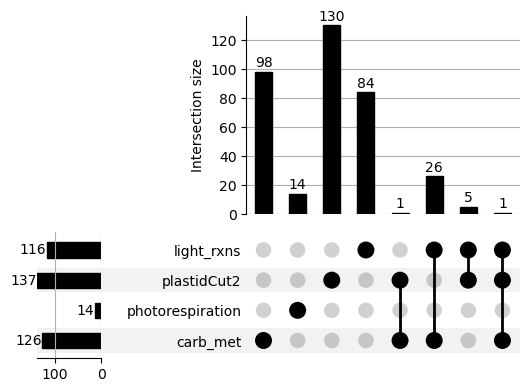

In [55]:
warnings.filterwarnings('ignore') 
to_plot = from_contents(genes_to_search)
plot(to_plot, show_counts=True, sort_categories_by='input')

We want to assign genes to one of these groups uniquely; we'll do this by putting it in the most specific category. The order of specificity for these groups, from least to most:
* PlastidCut
* Carbohydrate Metabolism
* Light reactions
* Photorespiration

In [56]:
specificity = ['plastidCut2', 'carb_met', 'light_rxns', 'photorespiration']
unique_genes_to_search = {}
for i, cat in enumerate(specificity[:-1]):
    current_cat = set(genes_to_search[cat])
    for subcat in specificity[i+1:]:
        prev_len = len(current_cat)
        current_cat -= set(genes_to_search[subcat])
        print(f'Removed {prev_len - len(current_cat)} genes from {cat} using {subcat}')
    unique_genes_to_search[cat] = list(current_cat)
unique_genes_to_search['photorespiration'] = genes_to_search['photorespiration'] 

Removed 2 genes from plastidCut2 using carb_met
Removed 5 genes from plastidCut2 using light_rxns
Removed 0 genes from plastidCut2 using photorespiration
Removed 27 genes from carb_met using light_rxns
Removed 0 genes from carb_met using photorespiration
Removed 0 genes from light_rxns using photorespiration


Check that it worked:

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

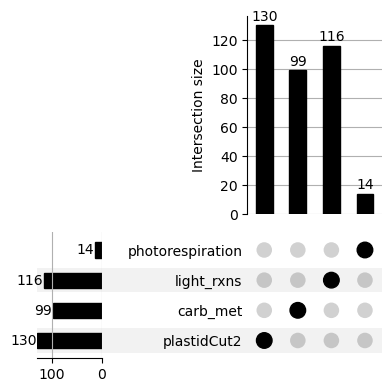

In [57]:
warnings.filterwarnings('ignore') 
to_plot = from_contents(unique_genes_to_search)
plot(to_plot, show_counts=True, sort_categories_by='input')

Save as a json for easier use in proteomics notebook:

In [58]:
with open('../data/photosynthesis_genes/all_photosynthesis_genes_unique.json', 'w') as f:
    json.dump(genes_to_search, f)

Now check whether genes from these conditions are present in the comparisons:

In [62]:
gene_groups = {k: [i.lower() for i in v] for k, v in genes_in_comps.items()}
gene_groups.update(unique_genes_to_search)

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

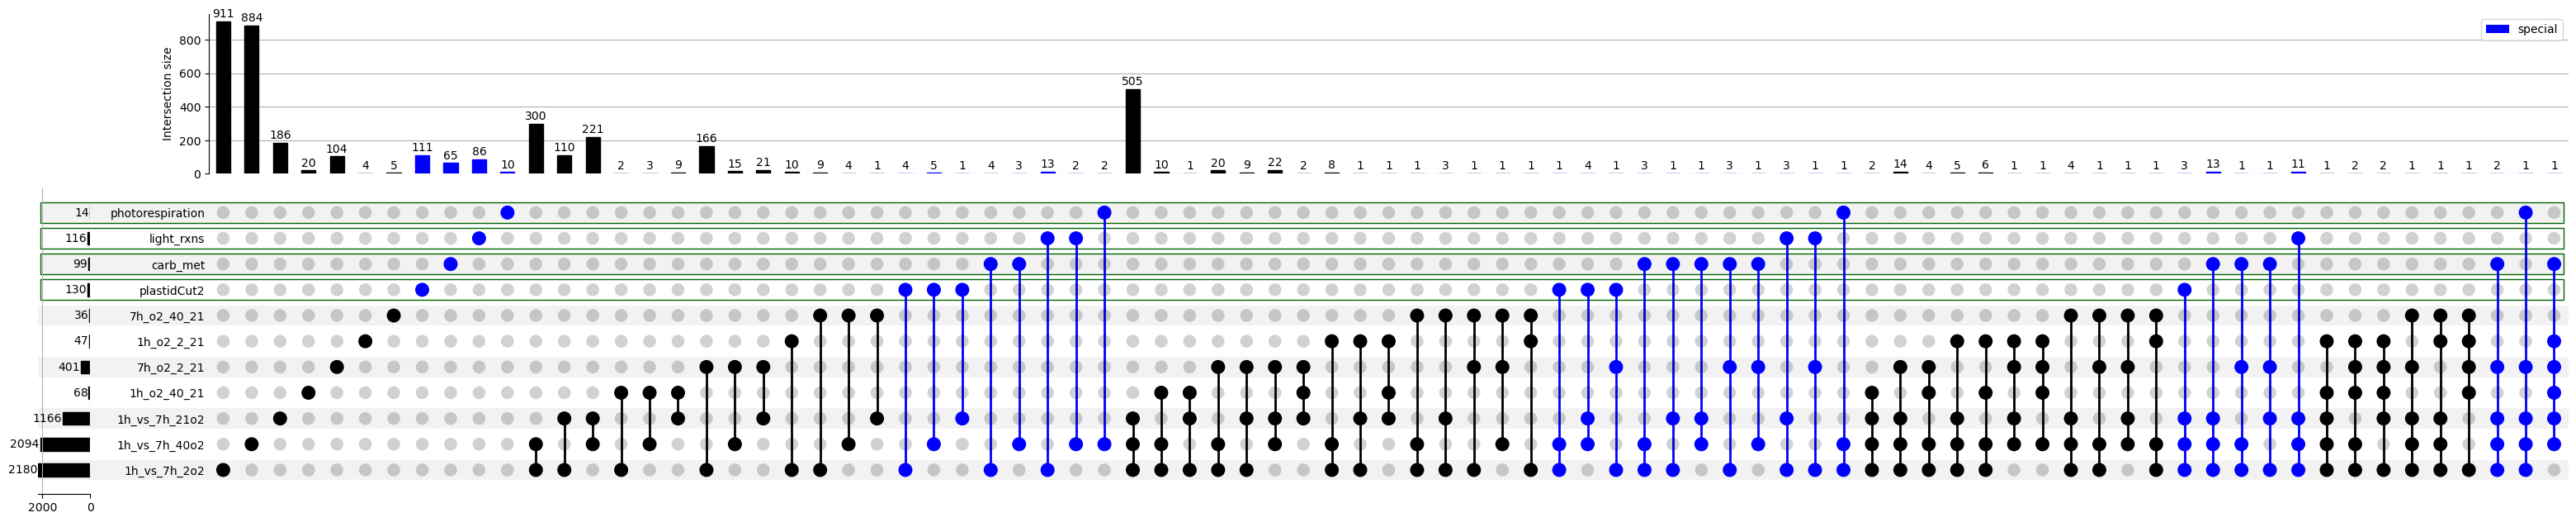

In [64]:
warnings.filterwarnings('ignore') 
to_plot = from_contents(gene_groups)

upset = UpSet(to_plot, show_counts=True, sort_categories_by='input')
upset.style_categories(list(genes_to_search.keys()), shading_edgecolor="darkgreen", shading_linewidth=1)
for c in genes_to_search.keys():
    upset.style_subsets(present=c, facecolor="blue", label="special")
upset.plot()

There is a relatively minimal amount of overlap between the photosynthesis genes and those genes that are differentially expressed. For those genes that are present, what are the expression behaviors in the dataset?

We are interested in three pieces of information with this visualization:
* What DEG sets it’s in
* What the expression changes in each DEG set looks like
* Which photosynthesis gene group it came from

We're going to do this by stacking one subfigure per DEG set, put all genes that appear anywhere in the x-axis of all of them, and color the bars by the pathway in which they appear.

In [35]:
all_comparisons.keys()

dict_keys(['1h_vs_7h_2o2', '1h_vs_7h_40o2', '1h_vs_7h_21o2', '1h_o2_40_21', '7h_o2_2_21', '1h_o2_2_21', '7h_o2_40_21'])

In [190]:
def makeDEGfigure(deg_dfs, photosynth_sets, photosynth_colors, semantic_names, tair2gene, legend_semantic):
    """
    Maked stacked expresion figure.

    parameters:
        deg_dfs, dict: keys are comparison names, values are dfs with
            log2FC values for significant DEGs
        photosynth_sets, dict: keys are set names, values are lists of
            gene names
        photosynth_colors, dict: keys are photosynth gene categories,
            values are colors to use
        semantic_names, dict: keys are the keys of deg_dfs, values are
            semantic names to be used as subplot titles
        tair2gene, dict: keys are lwoercased TAIR ID's of the genes in the
            plot, values are the gene names
        legend_semantic, dict: keys are the keys of photosynth sets, values are
            semantic names to be used in legend
    """
    # Capitalize the photosynthesis 
    # Get the overall list of all photosynth genes that appear in any DEG set
    # These will be the x axis for all plots
    all_photosynth = [g.upper() for s in photosynth_sets.values() for g in s]
    all_degs = [g.upper() for g_list in [df.gene_id.tolist() for df in deg_dfs.values()] for g in g_list]
    x_genes = set(all_photosynth).intersection(all_degs)
    
    # Make a color dict for all the sets
    g_to_group = {}
    for ph, gs in photosynth_sets.items():
        for g in gs:
            g_to_group[g] = ph
    color_dict = {g: photosynth_colors[ph] for g, ph in g_to_group.items()}

    # Get the intersections of the photosynth sets with the DEG conditions
    to_plot = {}
    for deg_set_name, deg_set in deg_dfs.items():
        photosynth = deg_set[deg_set.gene_id.isin(all_photosynth)][['gene_id', 'log2FoldChange']]
        not_present = {'gene_id': [g for g in x_genes if g not in photosynth.gene_id.tolist()]}
        not_present['log2FoldChange'] = [0]* len(not_present['gene_id'])
        to_plot_df = pd.concat([photosynth, pd.DataFrame(not_present)])
        to_plot_df['gene_id'] = to_plot_df['gene_id'].str.lower()
        to_plot[deg_set_name] = to_plot_df

    # Plot
    fig, axs = plt.subplots(len(to_plot), sharex=True, sharey=True, figsize=(20, len(to_plot)*5))

    for deg_set_name, ax in zip(to_plot.keys(), axs.flat):
        
        current_set = to_plot[deg_set_name]
        nonzero = len(current_set[current_set['log2FoldChange'] != 0])
        labels = [g_to_group[g] for g in current_set.gene_id]
        colors = [color_dict[g] for g in current_set.gene_id]
        ax.bar(current_set['gene_id'], current_set['log2FoldChange'], label=labels, color=colors)
        ax.set_title(semantic_names[deg_set_name] + f': {nonzero} DE genes')
        ax.tick_params(axis='x', labelrotation=90, labelbottom=True)
        xtick_labels = ax.get_xticklabels()

    # Write over xtick labels with extra semantic stuff
    semantic_xticklabels = []
    for g in xtick_labels:
        try:
            semantic_xticklabels.append(f'{g.get_text().upper()} ({tair2gene[g.get_text()]})')
        except KeyError:
            semantic_xticklabels.append(f'{g.get_text().upper()}')
    for ax in axs.flat:
        ax.set_xticklabels(semantic_xticklabels, rotation=90)

    fig.supylabel('log2FoldChange', x=ax.get_position().x0 - 0.05)
    
    # To remove duplicate labels
    lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    unique_labels = set(labels)
    legend_dict = dict(zip(labels, lines))
    unique_lines = [legend_dict[x] for x in unique_labels]
    legend_x = axs.flatten()[-1].get_position().xmax
    legend_y = axs.flatten()[0].get_position().ymax
    fig.legend(unique_lines, [legend_semantic[l] for l in unique_labels], loc=(8.75*legend_x/10, legend_y + legend_y/20)) # This may not generalize well, did by trial and error

    plt.subplots_adjust(hspace=1)

In [191]:
ara = pd.read_csv('../data/gene_aliases_20241231.txt', sep='\t', header=0, encoding='Windows-1252')
tair2gene = {k.lower(): v for k, v in ara.set_index('locus_name')[['symbol']].to_dict()['symbol'].items()}

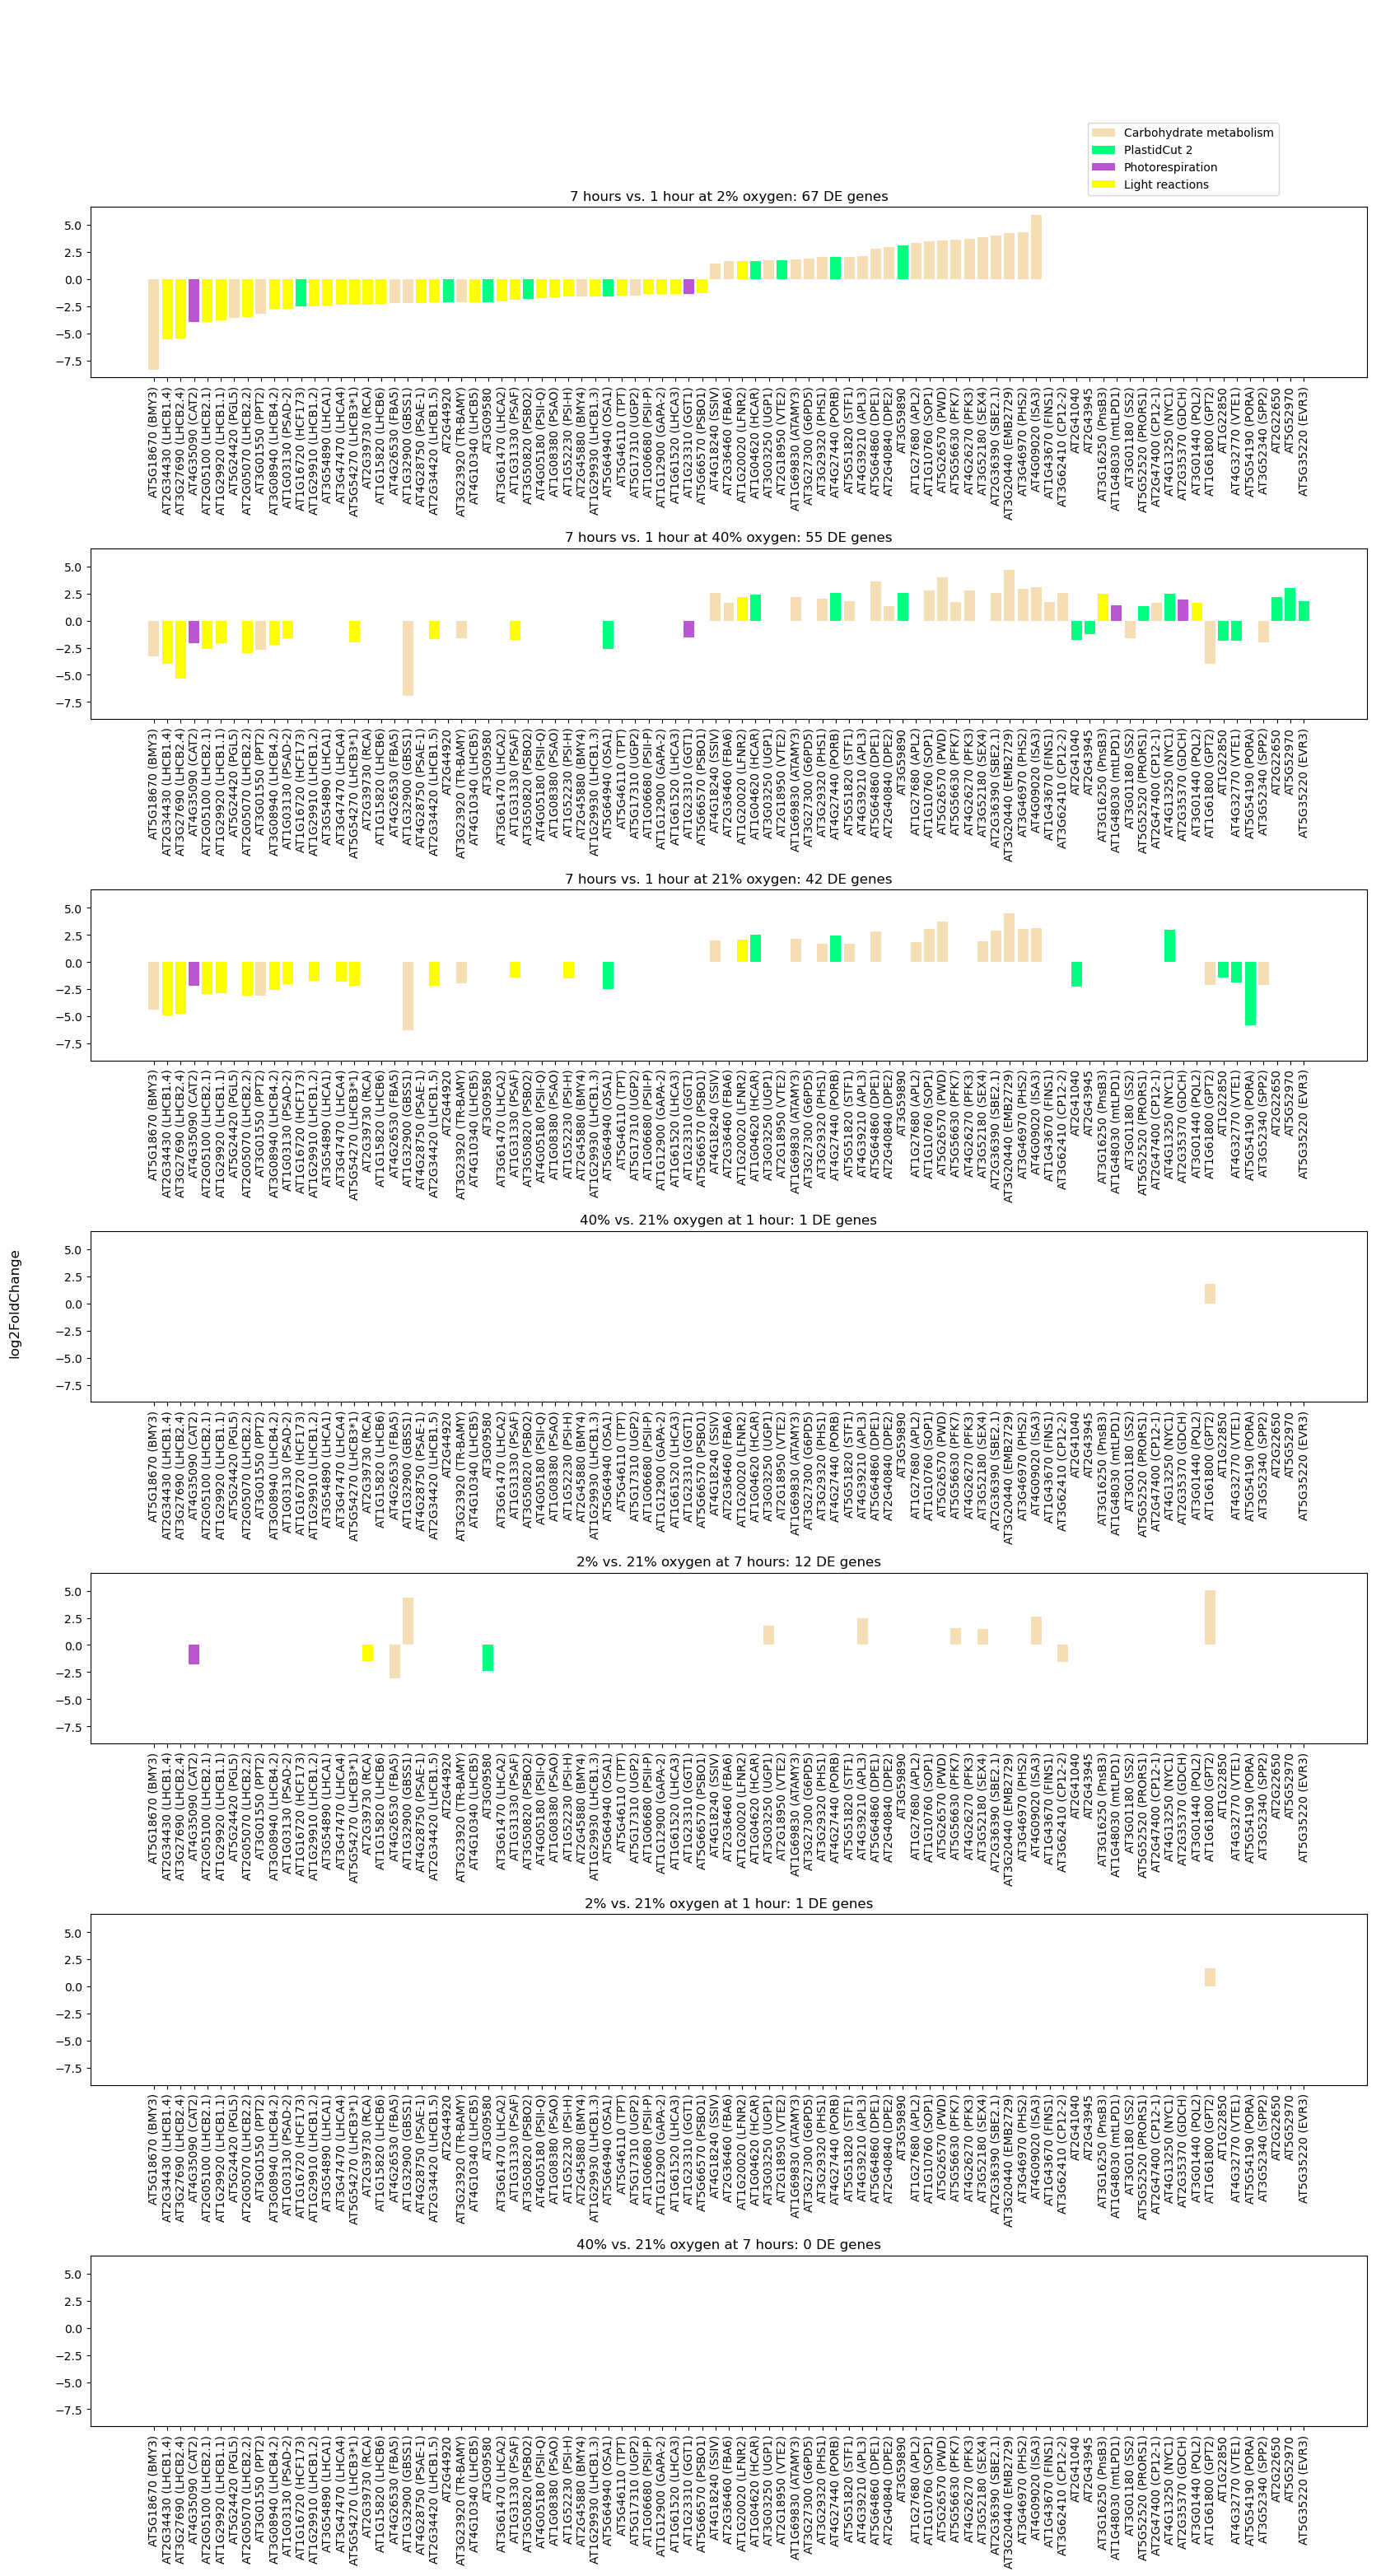

In [192]:
semantic_names = {
    '1h_vs_7h_2o2': '7 hours vs. 1 hour at 2% oxygen',
    '1h_vs_7h_40o2': '7 hours vs. 1 hour at 40% oxygen',
    '1h_vs_7h_21o2': '7 hours vs. 1 hour at 21% oxygen',
    '1h_o2_40_21': '40% vs. 21% oxygen at 1 hour',
    '7h_o2_2_21': '2% vs. 21% oxygen at 7 hours',
    '1h_o2_2_21': '2% vs. 21% oxygen at 1 hour',
    '7h_o2_40_21': '40% vs. 21% oxygen at 7 hours'
}
photosynth_colors = {'plastidCut2': 'springgreen', 'carb_met': 'wheat', 'light_rxns': 'yellow', 'photorespiration': 'mediumorchid'}
legend_semantic = {'plastidCut2': 'PlastidCut 2', 'carb_met': 'Carbohydrate metabolism', 'light_rxns': 'Light reactions', 'photorespiration': 'Photorespiration'}
makeDEGfigure(all_comparisons, unique_genes_to_search, photosynth_colors, semantic_names, tair2gene, legend_semantic)